# The Error Correction RNN

## Index

1. Task
2. Data
2. An Off-the-shelf Seq2Seq RNN
3. Training and Evaluation

## Section 1: Task

The network we're about to train is not going to directly serve any practical application. 
It's meant to serve as a proof of concept. 

We want to show in principle that a neural network can be used to **reconstruct a document from faulty copies** of that document. 

The concept is meant to be used in my course project (see https://www.dropbox.com/s/941wnu50197gshs/DLAM_Expose.pdf?dl=0%29).

### 1.1 Example

A task for our network will look like this:

```
Original = crying

Copy1 = crn
Copy2 = orreng
Copy3 = crywing

```

The network receives the copies as an input and reconstructs the original word.

```
Network output = crying
```

## Section 2: Data

In [1]:
# load tokenized sentences from the gutenberg corpus
import nltk
#nltk.download('gutenberg')
#nltk.download('punkt')
#nltk.download('reuters')
from nltk.corpus import gutenberg

sents = []
for fileid in gutenberg.fileids():
    for sent in gutenberg.sents(fileid):
        sents.append(sent)

print('Number of words in dataset:\t', sum(len(sent) for sent in sents))
print('\nExample dataset entry:\n', sents[195])

Number of words in dataset:	 2621785

Example dataset entry:
 ['Now', ',', 'upon', 'his', 'father', "'", 's', 'marriage', ',', 'it', 'was', 'very', 'generally', 'proposed', ',', 'as', 'a', 'most', 'proper', 'attention', ',', 'that', 'the', 'visit', 'should', 'take', 'place', '.']


In [2]:
sents = sents[:1000]
print(len(sents))

1000


### Load Test Data

In [3]:
from nltk.corpus import reuters

testsents = []
for fileid in reuters.fileids():
    for sent in reuters.sents(fileid):
        testsents.append(sent)

print('Number of words in dataset:\t', sum(len(sent) for sent in testsents))
print('\nExample dataset entry:\n', testsents[195])

testsents = testsents[:1000]

Number of words in dataset:	 1720917

Example dataset entry:
 ['Kim', 'said', 'the', 'swing', 'of', 'South', 'Korea', "'", 's', 'current', 'account', 'to', 'a', 'surplus', 'of', '4', '.', '65', 'billion', 'dlrs', 'in', '1986', 'from', 'an', '890', 'mln', 'dlr', 'deficit', 'in', '1985', 'was', 'very', 'significant', '.']


In [4]:
allsents = sents + testsents

### 2.1 : Faulty Copy Machines

We will be using 3 different 'faulty copy machines' to generate the input for the network.

Each FCM will induce a certain kind of error with a certain probability.

In [5]:
import random
from random import randint
# use a seed for reproducibility
random.seed(1995)

#### FCM Hamburg
The fcm_hamburg will skip characters with a certain probability

In [6]:
HAMBURG_ERROR_PROB = 0.4

# create faulty copy machine hamburg
def fcm_hamburg(original_sents):
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # skip characters with a certain probability
            copy_token = ''.join([char for char in original_token if random.random() > HAMBURG_ERROR_PROB])
            copy_sent.append(copy_token)
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Hamburg Example

In [7]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Hamburg Sentence:\n",fcm_hamburg([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Hamburg Sentence:
 [['Her', 'mothe', 'had', 'died', 'too', 'long', 'go', 'o', 'he', 'o', 'hav', 'm', 'th', 'a', 'distint', 'rembrnc', '', 'h', 'carsss', ';', 'and', 'hr', 'ace', 'ha', 'e', 'suppi', 'b', 'a', 'eele', 'oma', 's', 'gonss', '', 'wh', 'had', 'falen', 'll', 'sr', 'f', 'a', 'm', 'i', 'ffcon', '.']]


#### FCM Lisboa
fcm_lisboa replaces characters in it's copy with a certain probability.

The replacement-character for a character will always be the same.

In [8]:
LISBOA_ERROR_PROB = 0.3

charset = [char for sent in allsents
                  for token in sent
                  for char in token]

# create the mapping that defines by which character another character will be replaced
lisboa_char_map = {}
for char in set(charset):
    lisboa_char_map[char] = random.choice(charset)

def fcm_lisboa(original_sents, error_prob=0):
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # replace certain chars with other certain chars with 
            copy_token = []
            for char in original_token:
                if random.random() < LISBOA_ERROR_PROB:
                    copy_char = lisboa_char_map[char]
                else:
                    copy_char = char
                copy_token.append(copy_char)
            copy_sent.append(''.join(copy_token))
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Lisboa Example

In [9]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Lisboa Sentence:\n",fcm_lisboa([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Lisboa Sentence:
 [['Hee', 'moMher', 'had', 'dred', 'tfo', 'lfng', 'ago', 'for', 'hne', 'to', 'have', 'mfen', 'Mean', 'an', 'inurstinet', 'eemnebrance', 'of', 'hnr', 'caeesses', ';', 'ald', 'her', 'plhce', 'hhu', 'benn', 'supplinu', 'by', 'an', 'exeehlenM', 'wfean', 'as', 'goveennee', 'u', 'who', 'hau', 'fhllen', 'hrtMle', 'shfrt', 'ff', 'h', 'mothne', 'il', 'affnctiol', 'h']]


#### FCM Madrid

FCM Madrid inserts random characters with a certain probability

In [10]:
MADRID_ERROR_PROB = 0.4
# create faulty copy machine madrid
# FCM Madrid inserts random characters with a certain probability

def fcm_madrid(original_sents, error_prob=0):
    charset = [char for sent in original_sents
                  for token in sent
                  for char in token]
    
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # insert random chars with a certain probability
            copy_token = []
            for char in original_token:
                if random.random() < MADRID_ERROR_PROB:
                    copy_token.append(charset[randint(0, len(charset)-1)])
                copy_token.append(char)
            copy_sent.append(''.join(copy_token))
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Lisboa Example

In [11]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Madrid Sentence:\n",fcm_madrid([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Madrid Sentence:
 [['Her', 'montfhfer', 'haad', 'odied', 'troo', 'long', 'natgo', 'efro.r', 'hcer', 'rto', 'ihave', 'amhore', 'thoan', 'an', 'ienrdisitinect', 'retmoembraaonce', 'of', 'her', 'mcaarleosses', ';', 'laned', 'ohefr', 'pnldacee', 'had', 'beetn', 'sauppsli;ed', 'obby', 'oatn', 'aefxtcellent', 'twnoameann', 'oas', 'tgolvrernesrs', 'b,', 'who', 'had', 'fealblen', 'litatlce', 'shoorat', 'ohf', 'la', 'mlorther', 'isn', 'oaiffecttriorn', '.']]


#### Feature Representation
We are using a sequence to sequence network, that was originally created for the task of language-translation. To make the output sequences of our three copy machines consumable for the network we have to represent as a single sequence. 

We do that by concatinating them character by character as shown in the following example:


In [12]:
def feature_word(original_word, prints=False):
    result = []
    hamburg_word = ''.join(fcm_hamburg([original_word])[0])
    lisboa_word = ''.join(fcm_lisboa([original_word])[0])
    madrid_word = ''.join(fcm_madrid([original_word])[0])
    if prints:
        print("Hamburg: ", hamburg_word)
        print("Lisboa : ", lisboa_word)
        print("Madrid : ", madrid_word)
        print()
    feature_word = []
    word_lens = [len(word) for word in [hamburg_word, lisboa_word, madrid_word, original_word]]
    for char_idx in range(max(word_lens)):
        feature_char = ''
        try:
            feature_char += hamburg_word[char_idx]
        except(IndexError):
            feature_char += '#'
        try:
            feature_char += lisboa_word[char_idx]
        except(IndexError):
            feature_char += '#'
        try:
            feature_char += madrid_word[char_idx]
        except(IndexError):
            feature_char += '#'
        if prints:
            print(feature_char)
        result += list(feature_char)
        
    if prints:
        print('\n')
    return result
print(feature_word('Maximilian', prints=True))

Hamburg:  aximlian
Lisboa :  Maximihian
Madrid :  MaxiMmmillian

aMM
xaa
ixx
mii
lmM
iim
ahm
nii
#al
#nl
##i
##a
##n


['a', 'M', 'M', 'x', 'a', 'a', 'i', 'x', 'x', 'm', 'i', 'i', 'l', 'm', 'M', 'i', 'i', 'm', 'a', 'h', 'm', 'n', 'i', 'i', '#', 'a', 'l', '#', 'n', 'l', '#', '#', 'i', '#', '#', 'a', '#', '#', 'n']


In [13]:
def build_feature_label_pairs(original_sents):
    result = []
    for original_sent in original_sents:
        hamburg_sent = fcm_hamburg([original_sent])[0]
        lisboa_sent = fcm_lisboa([original_sent])[0]
        madrid_sent = fcm_madrid([original_sent])[0]
        
        feature_sent = []
        
        for idx, original_word in enumerate(original_sent):
            result.append([feature_word(original_word), list(original_word)])
            
        #result.append([feature_sent, list(' '.join(original_sent))])
    return result

In [14]:
data_pair = build_feature_label_pairs([sents[4]])[0]
feature = data_pair[0]
label = data_pair[1]
print("Feature:\n", feature)
print("\n")
print("Label:\n", label)

Feature:
 ['S', 'S', 'S', 'h', 'h', 'S', 'e', 'n', 'e', '#', '#', 'h', '#', '#', 'e']


Label:
 ['S', 'h', 'e']


In [15]:
# We're using this function to extend the dataset with nonsensical words
# We hope that by this, the network will overfit less to english language
def build_shuffle_pairs(sents):
    shuffled_sents = []
    for sent in sents:
        shuffled_sent = []
        for word in sent:
            shuffled_word = list(word)
            random.shuffle(shuffled_word)
            shuffled_sent.append(''.join(shuffled_word))
        shuffled_sents.append(shuffled_sent)
    return build_feature_label_pairs(shuffled_sents)

In [16]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        for char in word:
            self.addChar(char)
            
    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [17]:
def prepareData(factor):
    input_lang = Lang('flawed_chars')
    output_lang = Lang('correct_chars')
    pairs = []
    for i in range(factor):
        pairs += build_feature_label_pairs(sents)
    pairs += build_shuffle_pairs(sents)
    print("Read %s word pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(1)
for char in charset:
    input_lang.addWord(char)
    output_lang.addWord(char)
sents = None

Read 46634 word pairs
Counting words...
Counted words:
flawed_chars 74
correct_chars 72


## Section 3: An Off-the-shelf Seq2Seq RNN

The code for the network is taken from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.

It was originally made for language translation and I adapted a few parts in order for it to handle words instead of sentences.

In [18]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
feature_lens = []
for pair in pairs:
    feature_lens.append(len(pair[0]))
MAX_LENGTH = max(feature_lens)
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
def indexesFromSentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [23]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [24]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [25]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.008):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # showPlot(plot_losses)
    return plot_losses

In [26]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [27]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    print("input: ", sentence)
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()
            
        print(decoded_words)

        return decoded_words, decoder_attentions[:di + 1]


In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        
        hamburg = ''
        lisboa = ''
        madrid = ''
        i = 0
        while i < len(pair[0]):
            hamburg += pair[0][i]
            lisboa += pair[0][i+1]
            madrid += pair[0][i+2]
            i += 3
        print('Hamburg >', hamburg)
        print('Lisboa >', lisboa)
        print('Madrid >', madrid)            
        print('=', ''.join(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words[:-1])
        print('<', output_sentence)
        print('')

## Section 4: Training and Evaluation

0m 1s (- 0m 14s) (5 8%) 3.4005
0m 1s (- 0m 7s) (10 16%) 2.9675
0m 1s (- 0m 5s) (15 25%) 3.0768
0m 1s (- 0m 3s) (20 33%) 2.3341
0m 2s (- 0m 2s) (25 41%) 2.6627
0m 2s (- 0m 2s) (30 50%) 2.8318
0m 2s (- 0m 1s) (35 58%) 2.0095
0m 2s (- 0m 1s) (40 66%) 2.0628
0m 3s (- 0m 1s) (45 75%) 3.1205
0m 3s (- 0m 0s) (50 83%) 2.1592
0m 3s (- 0m 0s) (55 91%) 1.8657
0m 3s (- 0m 0s) (60 100%) 2.9076


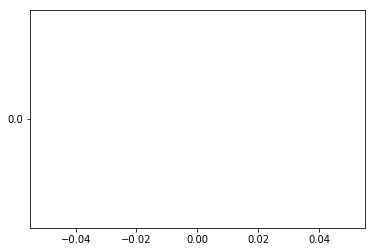

In [29]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

points = trainIters(encoder1, attn_decoder1, 60, print_every=5)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(points)
plt.show()

In [30]:
evaluateRandomly(encoder1, attn_decoder1)

Hamburg > tllt######
Lisboa > MheliM####
Madrid > etlltelitt
= tlelit
input:  ['t', 'M', 'e', 'l', 'h', 't', 'l', 'e', 'l', 't', 'l', 'l', '#', 'i', 't', '#', 'M', 'e', '#', '#', 'l', '#', '#', 'i', '#', '#', 't', '#', '#', 't']
['<EOS>']
< 

Hamburg > ##
Lisboa > e#
Madrid > ""
= "
input:  ['#', 'e', '"', '#', '#', '"']
['<EOS>']
< 

Hamburg > ccke#####
Lisboa > cockhue##
Madrid > cocokaode
= cockade
input:  ['c', 'c', 'c', 'c', 'o', 'o', 'k', 'c', 'c', 'e', 'k', 'o', '#', 'h', 'k', '#', 'u', 'a', '#', 'e', 'o', '#', '#', 'd', '#', '#', 'e']
['<EOS>']
< 

Hamburg > enwgdlo######
Lisboa > elwkndeho####
Madrid > kednkwkgdwelo
= enwkgdelo
input:  ['e', 'e', 'k', 'n', 'l', 'e', 'w', 'w', 'd', 'g', 'k', 'n', 'd', 'n', 'k', 'l', 'd', 'w', 'o', 'e', 'k', '#', 'h', 'g', '#', 'o', 'd', '#', '#', 'w', '#', '#', 'e', '#', '#', 'l', '#', '#', 'o']
['<EOS>']
< 

Hamburg > odbyno#
Lisboa > odbyno#
Madrid > oodbyno
= odbyno
input:  ['o', 'o', 'o', 'd', 'd', 'o', 'b', 'b', 'd', 'y', 'y', 'b', 'n', 'n

In [31]:
def computeAccuracy(encoder, decoder):
    pairs=build_feature_label_pairs(testsents)
    n=len(testsents)
    for i in range(n):
        tp=0
        acc=0
        pair = random.choice(pairs)
        
        hamburg = ''
        lisboa = ''
        madrid = ''
        i = 0
        while i < len(pair[0]):
            hamburg += pair[0][i]
            lisboa += pair[0][i+1]
            madrid += pair[0][i+2]
            i += 3
        print('Hamburg >', hamburg)
        print('Lisboa >', lisboa)
        print('Madrid >', madrid)            
        print('=', ''.join(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words[:-1])
        print('<', output_sentence)
        print('Output == Input?', pair[1]==output_sentence)
        print('')
        if pair[1]==output_sentence:
            tp=+1
        acc=tp/n
    print('accuracy =', acc)

In [32]:
computeAccuracy(encoder1, attn_decoder1)

Hamburg > r####
Lisboa > tor##
Madrid > ofoor
= for
input:  ['r', 't', 'o', '#', 'o', 'f', '#', 'r', 'o', '#', '#', 'o', '#', '#', 'r']
['<EOS>']
< 
Output == Input? False

Hamburg > -
Lisboa > -
Madrid > -
= -
input:  ['-', '-', '-']
['<EOS>']
< 
Output == Input? False

Hamburg > fort######
Lisboa > efforte###
Madrid > esfforetss
= efforts
input:  ['f', 'e', 'e', 'o', 'f', 's', 'r', 'f', 'f', 't', 'o', 'f', '#', 'r', 'o', '#', 't', 'r', '#', 'e', 'e', '#', '#', 't', '#', '#', 's', '#', '#', 's']
['<EOS>']
< 
Output == Input? False

Hamburg > #
Lisboa > n
Madrid > '
= '
input:  ['#', 'n', "'"]
['<EOS>']
< 
Output == Input? False

Hamburg > Sh#
Lisboa > ihr
Madrid > Shr
= Shr
input:  ['S', 'i', 'S', 'h', 'h', 'h', '#', 'r', 'r']
['<EOS>']
< 
Output == Input? False

Hamburg > thre##
Lisboa > Meern#
Madrid > theere
= there
input:  ['t', 'M', 't', 'h', 'e', 'h', 'r', 'e', 'e', 'e', 'r', 'e', '#', 'n', 'r', '#', '#', 'e']
['<EOS>']
< 
Output == Input? False

Hamburg > #
Lisboa > ,
Madrid > 

['<EOS>']
< 
Output == Input? False

Hamburg > 1###
Lisboa > os##
Madrid > 5115
= 15
input:  ['1', 'o', '5', '#', 's', '1', '#', '#', '1', '#', '#', '5']
['<EOS>']
< 
Output == Input? False

Hamburg > -
Lisboa > r
Madrid > -
= -
input:  ['-', 'r', '-']
['<EOS>']
< 
Output == Input? False

Hamburg > cauioed######
Lisboa > castioneu####
Madrid > iceautioenied
= cautioned
input:  ['c', 'c', 'i', 'a', 'a', 'c', 'u', 's', 'e', 'i', 't', 'a', 'o', 'i', 'u', 'e', 'o', 't', 'd', 'n', 'i', '#', 'e', 'o', '#', 'u', 'e', '#', '#', 'n', '#', '#', 'i', '#', '#', 'e', '#', '#', 'd']
['<EOS>']
< 
Output == Input? False

Hamburg > 7
Lisboa > g
Madrid > 7
= 7
input:  ['7', 'g', '7']
['<EOS>']
< 
Output == Input? False

Hamburg > that#
Lisboa > MhaM#
Madrid > tahat
= that
input:  ['t', 'M', 't', 'h', 'h', 'a', 'a', 'a', 'h', 't', 'M', 'a', '#', '#', 't']
['<EOS>']
< 
Output == Input? False

Hamburg > tatet#######
Lisboa > statemnnt###
Madrid > sttsatemment
= statement
input:  ['t', 's', 's', 'a', 't', '

['<EOS>']
< 
Output == Input? False

Hamburg > -#
Lisboa > -#
Madrid > --
= -
input:  ['-', '-', '-', '#', '#', '-']
['<EOS>']
< 
Output == Input? False

Hamburg > b##
Lisboa > se#
Madrid > bee
= be
input:  ['b', 's', 'b', '#', 'e', 'e', '#', '#', 'e']
['<EOS>']
< 
Output == Input? False

Hamburg > #
Lisboa > ,
Madrid > ,
= ,
input:  ['#', ',', ',']
['<EOS>']
< 
Output == Input? False

Hamburg > W##
Lisboa > We#
Madrid > WWe
= We
input:  ['W', 'W', 'W', '#', 'e', 'W', '#', '#', 'e']
['<EOS>']
< 
Output == Input? False

Hamburg > lng######
Lisboa > falling##
Madrid > fialfling
= falling
input:  ['l', 'f', 'f', 'n', 'a', 'i', 'g', 'l', 'a', '#', 'l', 'l', '#', 'i', 'f', '#', 'n', 'l', '#', 'g', 'i', '#', '#', 'n', '#', '#', 'g']
['<EOS>']
< 
Output == Input? False

Hamburg > s#
Lisboa > e#
Madrid > ss
= s
input:  ['s', 'e', 's', '#', '#', 's']
['<EOS>']
< 
Output == Input? False

Hamburg > ,#
Lisboa > ,#
Madrid > ,,
= ,
input:  [',', ',', ',', '#', '#', ',']
['<EOS>']
< 
Output == Input?

['<EOS>']
< 
Output == Input? False

Hamburg > FRSAC########
Lisboa > FIuSTBANC####
Madrid > TFTIRSTBAINFC
= FIRSTBANC
input:  ['F', 'F', 'T', 'R', 'I', 'F', 'S', 'u', 'T', 'A', 'S', 'I', 'C', 'T', 'R', '#', 'B', 'S', '#', 'A', 'T', '#', 'N', 'B', '#', 'C', 'A', '#', '#', 'I', '#', '#', 'N', '#', '#', 'F', '#', '#', 'C']
['<EOS>']
< 
Output == Input? False

Hamburg > oted####
Lisboa > noteu###
Madrid > ndodtted
= noted
input:  ['o', 'n', 'n', 't', 'o', 'd', 'e', 't', 'o', 'd', 'e', 'd', '#', 'u', 't', '#', '#', 't', '#', '#', 'e', '#', '#', 'd']
['<EOS>']
< 
Output == Input? False

Hamburg > ELTONI############
Lisboa > CELLTRoNICS#######
Madrid > NCEELLTTREOTNLICCS
= CELLTRONICS
input:  ['E', 'C', 'N', 'L', 'E', 'C', 'T', 'L', 'E', 'O', 'L', 'E', 'N', 'T', 'L', 'I', 'R', 'L', '#', 'o', 'T', '#', 'N', 'T', '#', 'I', 'R', '#', 'C', 'E', '#', 'S', 'O', '#', '#', 'T', '#', '#', 'N', '#', '#', 'L', '#', '#', 'I', '#', '#', 'C', '#', '#', 'C', '#', '#', 'S']
['<EOS>']
< 
Output == Input? Fal

['<EOS>']
< 
Output == Input? False

Hamburg > ,#
Lisboa > u#
Madrid > ,,
= ,
input:  [',', 'u', ',', '#', '#', ',']
['<EOS>']
< 
Output == Input? False

Hamburg > 5#####
Lisboa > 19Es##
Madrid > 159895
= 1985
input:  ['5', '1', '1', '#', '9', '5', '#', 'E', '9', '#', 's', '8', '#', '#', '9', '#', '#', '5']
['<EOS>']
< 
Output == Input? False

Hamburg > t##
Lisboa > tee
Madrid > the
= the
input:  ['t', 't', 't', '#', 'e', 'h', '#', 'e', 'e']
['<EOS>']
< 
Output == Input? False

Hamburg > trades##
Lisboa > Mrauers#
Madrid > trarders
= traders
input:  ['t', 'M', 't', 'r', 'r', 'r', 'a', 'a', 'a', 'd', 'u', 'r', 'e', 'e', 'd', 's', 'r', 'e', '#', 's', 'r', '#', '#', 's']
['<EOS>']
< 
Output == Input? False

Hamburg > Man###
Lisboa > Mahn##
Madrid > MMaMhn
= Mahn
input:  ['M', 'M', 'M', 'a', 'a', 'M', 'n', 'h', 'a', '#', 'n', 'M', '#', '#', 'h', '#', '#', 'n']
['<EOS>']
< 
Output == Input? False

Hamburg > on
Lisboa > ol
Madrid > on
= on
input:  ['o', 'o', 'o', 'n', 'l', 'n']
['<EOS>']
< 


= holding
input:  ['l', 'h', 'n', 'd', 'o', 'h', '#', 'l', 'o', '#', 'd', 'l', '#', 'i', 'l', '#', 'n', 'd', '#', 'g', 'i', '#', '#', 'd', '#', '#', 'n', '#', '#', 'h', '#', '#', 'g']
['<EOS>']
< 
Output == Input? False

Hamburg > mo###
Lisboa > moen#
Madrid > mmore
= more
input:  ['m', 'm', 'm', 'o', 'o', 'm', '#', 'e', 'o', '#', 'n', 'r', '#', '#', 'e']
['<EOS>']
< 
Output == Input? False

Hamburg > dlrs#
Lisboa > dlre#
Madrid > dlsrs
= dlrs
input:  ['d', 'd', 'd', 'l', 'l', 'l', 'r', 'r', 's', 's', 'e', 'r', '#', '#', 's']
['<EOS>']
< 
Output == Input? False

Hamburg > ##
Lisboa > 15
Madrid > 15
= 15
input:  ['#', '1', '1', '#', '5', '5']
['<EOS>']
< 
Output == Input? False

Hamburg > T####
Lisboa > QdR##
Madrid > RQTTR
= QTR
input:  ['T', 'Q', 'R', '#', 'd', 'Q', '#', 'R', 'T', '#', '#', 'T', '#', '#', 'R']
['<EOS>']
< 
Output == Input? False

Hamburg > n##
Lisboa > fne
Madrid > one
= one
input:  ['n', 'f', 'o', '#', 'n', 'n', '#', 'e', 'e']
['<EOS>']
< 
Output == Input? False

Ham

['<EOS>']
< 
Output == Input? False

Hamburg > #
Lisboa > h
Madrid > .
= .
input:  ['#', 'h', '.']
['<EOS>']
< 
Output == Input? False

Hamburg > of
Lisboa > of
Madrid > of
= of
input:  ['o', 'o', 'o', 'f', 'f', 'f']
['<EOS>']
< 
Output == Input? False

Hamburg > La##
Lisboa > Ea##
Madrid > aLLa
= La
input:  ['L', 'E', 'a', 'a', 'a', 'L', '#', '#', 'L', '#', '#', 'a']
['<EOS>']
< 
Output == Input? False

Hamburg > ubber####
Lisboa > eubbee###
Madrid > ruubbrebr
= rubber
input:  ['u', 'e', 'r', 'b', 'u', 'u', 'b', 'b', 'u', 'e', 'b', 'b', 'r', 'e', 'b', '#', 'e', 'r', '#', '#', 'e', '#', '#', 'b', '#', '#', 'r']
['<EOS>']
< 
Output == Input? False

Hamburg > Coanie########
Lisboa > lfmohnres#####
Madrid > CoompmamniCeis
= Companies
input:  ['C', 'l', 'C', 'o', 'f', 'o', 'a', 'm', 'o', 'n', 'o', 'm', 'i', 'h', 'p', 'e', 'n', 'm', '#', 'r', 'a', '#', 'e', 'm', '#', 's', 'n', '#', '#', 'i', '#', '#', 'C', '#', '#', 'e', '#', '#', 'i', '#', '#', 's']
['<EOS>']
< 
Output == Input? False

Ham

IndexError: index 75 is out of bounds for dimension 0 with size 75